# Example Sensor Data ML Notebook
Examples of humidity and temperature sensor telemetry Machine Learning (ML) using scikit-learn (https://scikit-learn.org/stable/)

_Prepared by: [Gary A. Stafford](https://twitter.com/GaryStafford)   
Associated article: https://wp.me/p1RD28-6l6_

In [1]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
from dotenv import load_dotenv
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
%matplotlib inline

## Load Environment Variables and Establish MongoDB Atlas Connection

In [2]:
%%time
# load env vars from local .env file
load_dotenv()

# establish db connection
MONGODB_CONN = os.environ.get('MONGODB_CONN')
MONGODB_DB = os.environ.get('MONGODB_DB')
MONGODB_COL = os.environ.get('MONGODB_COL')

client = pymongo.MongoClient(MONGODB_CONN)
db = client[MONGODB_DB]
iot_data = db[MONGODB_COL]

CPU times: user 24.9 ms, sys: 7.44 ms, total: 32.3 ms
Wall time: 495 ms


## Define Panda DataFrames for (3) DHT Sensors
Panda DataFrames:
1. DataFrame 1: df1 = rb47a3d9f5
2. DataFrame 2: df2 = rp829c7e0e
3. DataFrame 3: df3 = rp47a3d9f5

In [3]:
DEVICE_1 = 'rp59adf374'
DEVICE_2 = 'rp829c7e0e'
DEVICE_3 = 'rp47a3d9f5'

### DataFrame 1

In [4]:
%%time
# aggregation created and exported from MongoDB Compass
# ~72-hour period from 5/11/2019 8:00:00 PM - 5/14/2019 8:00:00 PM
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_1, 
            'timestamp': {
                '$gt': 1557619200,
                '$lt': 1557878400
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'device': 1,
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df1 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df1['temperature'] = ((df1.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df1['temperature'].quantile(0.01)
df1 = df1[df1['temperature'] >= qt]
qh = df1['humidity'].quantile(0.01)
df1 = df1[df1['humidity'] >= qh]

CPU times: user 89.9 ms, sys: 15.6 ms, total: 105 ms
Wall time: 2.54 s


### DataFrame 2

In [5]:
%%time
# aggregation created and exported from MongoDB Compass
# ~72-hour period from 5/11/2019 8:00:00 PM - 5/14/2019 8:00:00 PM
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_2, 
            'timestamp': {
                '$gt': 1557619200,
                '$lt': 1557878400
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'device': 1,
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df2['temperature'] = ((df2.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df2['temperature'].quantile(0.01)
df2 = df2[df2['temperature'] >= qt]
qh = df2['humidity'].quantile(0.01)
df2 = df2[df2['humidity'] >= qh]

CPU times: user 65.5 ms, sys: 9.3 ms, total: 74.8 ms
Wall time: 613 ms


### DataFrame 3

In [6]:
%%time
# aggregation created and exported from MongoDB Compass
# ~32-hour period
# 2019-05-17 21:58:04.746520996-04:00
# 2019-05-19 07:59:55.743566036-04:00
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_3, 
            'timestamp': {
                '$gt': 1558094400,
                '$lt': 1558267200
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'device': 1,
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df3['temperature'] = ((df3.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df3['temperature'].quantile(0.01)
df3 = df3[df3['temperature'] >= qt]
qh = df3['humidity'].quantile(0.01)
df3 = df3[df3['humidity'] >= qh]

CPU times: user 34.3 ms, sys: 5.58 ms, total: 39.9 ms
Wall time: 325 ms


## Prepare Data for Modeling

In [7]:
# concat the (3) dataframes (different iot devices)
df_devices = [df1, df2, df3]
df_devices = pd.concat(df_devices, sort=False)
df_devices = df_devices.sample(frac=1)

# split dataframe into data and labels numpy.ndarray's
X = df_devices.iloc[:, [1,2]].values
y = df_devices.iloc[:, 0].values

# encode labels with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

print('df_devices:\n', df_devices.head(5), '\n')
print('X:\n', X[:5], '\n')
print('y:\n', y[:10], '\n')

df_devices:
           device   humidity  temperature
8456  rp829c7e0e  50.400002    69.619999
2889  rp829c7e0e  49.400002    70.160001
4311  rp829c7e0e  49.500000    69.439999
6010  rp59adf374  68.900002    62.419999
4812  rp59adf374  65.199997    63.500000 

X:
 [[50.40000153 69.61999931]
 [49.40000153 70.16000137]
 [49.5        69.43999863]
 [68.90000153 62.41999931]
 [65.19999695 63.5       ]] 

y:
 [2 2 2 1 1 0 2 2 0 1] 



In [8]:
df_devices.head(10)

,device,humidity,temperature
8456,rp829c7e0e,50.400002,69.619999
2889,rp829c7e0e,49.400002,70.160001
4311,rp829c7e0e,49.500000,69.439999
6010,rp59adf374,68.900002,62.419999
4812,rp59adf374,65.199997,63.500000
645,rp47a3d9f5,54.000000,66.739999
8216,rp829c7e0e,50.200001,69.800000
9054,rp829c7e0e,50.400002,69.980001
1732,rp47a3d9f5,55.200001,67.639999
852,rp59adf374,70.599998,61.880001


In [9]:
# split data into training and testing data
test_size = 0.25
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (19632, 2)
X_test: (6544, 2)


### Model/Data Plotting Function

In [10]:
# plot using mlxtend
def plot_model_mlxtend(clf, title):
    plt.figure(figsize=(14,7))
    plot_decision_regions(X, y, clf=clf, legend=1)
    plt.xlabel('Humidity (%)')
    plt.ylabel('Temperature (°F)')
    plt.title(title)
    plt.legend(title="Classes")
    plt.show()

In [11]:
# plot using matplotlib.pyplot
def plot_model_np(clf, title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=(14,7))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlabel('Humidity (%)')
    plt.ylabel('Temperature (°F)')
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    legend = ax.legend(*scatter.legend_elements(), title="Classes") # requires matplotlib >=3.1.0
    ax.add_artist(legend)
    plt.show()

### Computing Cross-Validation Metrics
<https://scikit-learn.org/stable/modules/cross_validation.html>

In [12]:
def cross_validation(model):
    model.score(X_test, y_test) 
    scores = cross_val_score(model, X_test, y_test, cv=5)
    return "Model accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

### Make Predictions using Model

In [13]:
def make_prediction(model, x, y):
    return le.inverse_transform(model.predict([[x, y]]))[0]

### Saving/Loading Models

In [14]:
def save_restore_model(model):
    # now you can save it to a file
    joblib_file = "joblib_model.pkl"  
    joblib.dump(model, joblib_file)

    # load from file
    joblib_model = joblib.load(joblib_file)

    # test loaded model
    print(make_prediction(model, 70, 65))
    print(make_prediction(model, 50, 70))
    print(make_prediction(model, 50, 65))

## Predictions using Support Vector Machine
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

References:
* <https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html>
* <https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code>
* <https://scikit-learn.org/stable/modules/svm.html#kernel-functions>

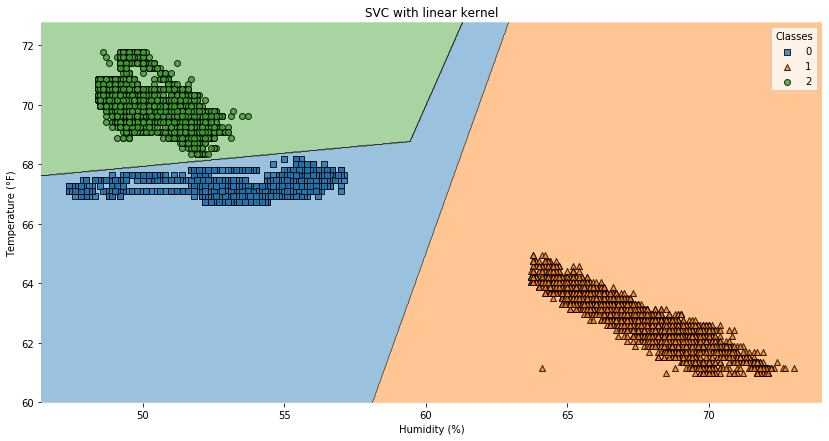

CPU times: user 1.51 s, sys: 95.1 ms, total: 1.6 s
Wall time: 1.53 s


In [15]:
%%time
# train C-Support Vector Classification (SVC) model and plot
title = 'SVC with linear kernel'
model = SVC(kernel='linear', C=1, gamma='auto')
model.fit(X_train, y_train)
plot_model_mlxtend(model, title)

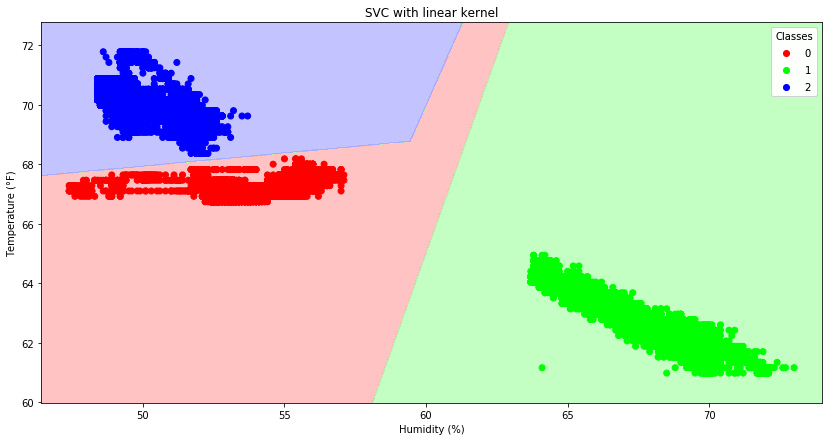

In [16]:
plot_model_np(model, title) 

In [17]:
# use linear SVC model
print(cross_validation(model))
print(make_prediction(model, 70, 65))
print(make_prediction(model, 50, 70))
print(make_prediction(model, 50, 65))
save_restore_model(model)

Model accuracy: 1.00 (+/- 0.00)
rp59adf374
rp829c7e0e
rp47a3d9f5
rp59adf374
rp829c7e0e
rp47a3d9f5


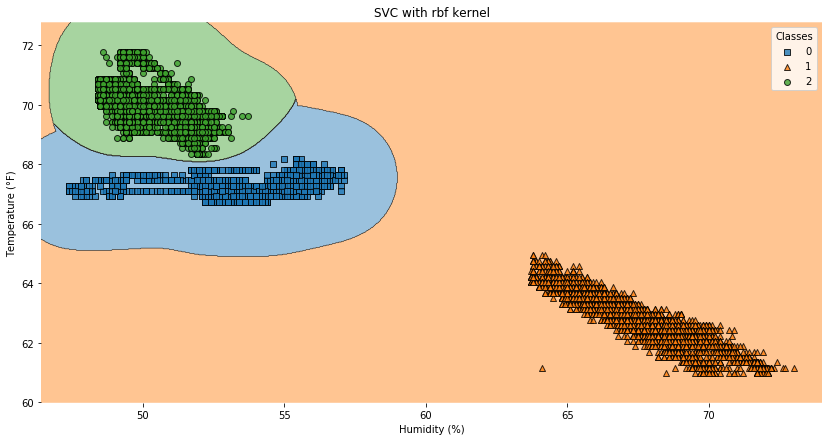

CPU times: user 2.2 s, sys: 102 ms, total: 2.3 s
Wall time: 2.22 s


In [18]:
%%time
# train C-Support Vector Classification (SVC) model and plot
model = SVC(kernel='rbf', C=1, gamma='auto')
model.fit(X_train, y_train)
plot_model_mlxtend(model, 'SVC with rbf kernel')

In [19]:
# use rbf SVC model
print(cross_validation(model))
print(make_prediction(model, 70, 65))
print(make_prediction(model, 50, 70))
print(make_prediction(model, 50, 65))

Model accuracy: 1.00 (+/- 0.00)
rp59adf374
rp829c7e0e
rp59adf374


## Predictions using K-Nearest Neighbors Classifier
* k-nearest neighbors algorithm (k-NN)
* <https://en.wikipedia.org/wiki/K-nearest_neighbor_algorithm>

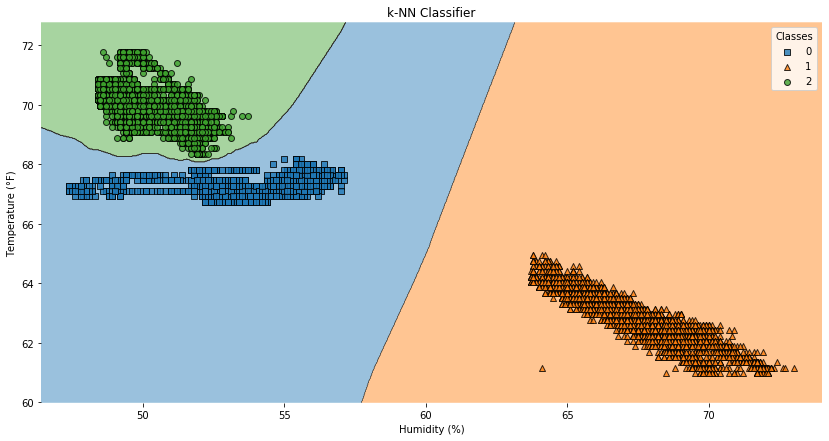

CPU times: user 17.3 s, sys: 415 ms, total: 17.7 s
Wall time: 17.7 s


In [20]:
%%time
# train k-NN model and plot
model = KNeighborsClassifier(n_neighbors=2, algorithm='auto')
model.fit(X_train, y_train)
plot_model_mlxtend(model, 'k-NN Classifier')

In [21]:
# use k-NN model
print(cross_validation(model))
print(make_prediction(model, 70, 65))
print(make_prediction(model, 50, 70))
print(make_prediction(model, 50, 65))

Model accuracy: 1.00 (+/- 0.00)
rp59adf374
rp829c7e0e
rp47a3d9f5


## Predictions using Random Forest Classifier
* Estimator that fits a number of decision tree classifiers on various sub-samples of the dataset
* Uses averaging to improve the predictive accuracy and control over-fitting
* <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>

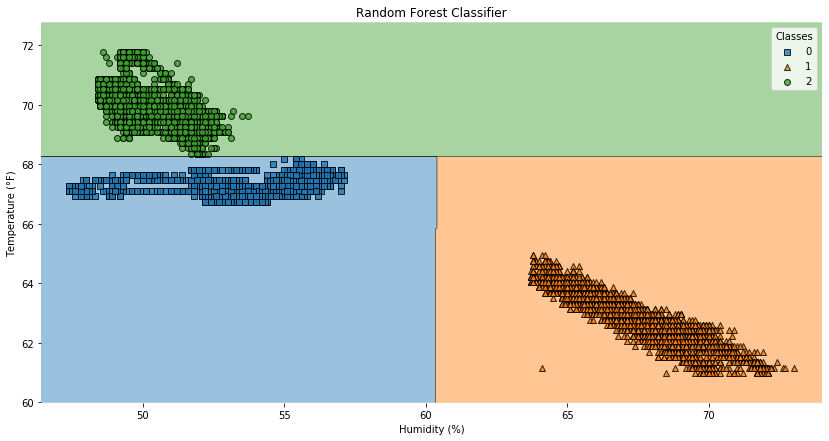

CPU times: user 3.81 s, sys: 274 ms, total: 4.08 s
Wall time: 4.05 s


In [22]:
%%time
# train Random Forest Classifier model and plot
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train, y_train)
plot_model_mlxtend(model, 'Random Forest Classifier')

In [23]:
# use Random Forest Classifier model
print(cross_validation(model))
print(make_prediction(model, 70, 65))
print(make_prediction(model, 50, 70))
print(make_prediction(model, 50, 65))

Model accuracy: 1.00 (+/- 0.00)
rp59adf374
rp829c7e0e
rp47a3d9f5
